In [1]:
# Math 551: uMass Amherst Fall 2022

import os
import numpy as np
import matplotlib.pyplot as plt

# For output
homedir = os.path.expanduser('~')

# Problem 1

The goal of this program is to compute the relative error of the fast inverse square root function. In particular, 
you are to determine how many iterations of Newton method are required.

The Q_rsqrt function is taken from [the Quake-III engine](https://github.com/id-Software/Quake-III-Arena/blob/master/code/game/q_math.c#L552). Below, we create a few files so that we can call that C-function from python.

### Define the c-function Q_rsqrt

Make sure that there is now additional commentary before the magic commant ``%%writefile''.

In [2]:
%%writefile isqrt.c
#include <stdint.h>
static float Q_rsqrt(float x)
{
    uint32_t i; // Changed to force a 32-bit integer. Most modern computers use a 64-bit for long.
    float x2, y;
    const float threehalfs = 1.5F;

    x2 = x * 0.5F;
    y  = x;
    i  = * ( uint32_t * ) &y;                   // evil floating point bit level hacking
    i  = 0x5f3759df - ( i >> 1 );               // what the fuck?
    y  = * ( float * ) &i;
    y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
//  y  = y * ( threehalfs - ( x2 * y * y ) );   // 2nd iteration, this can be removed
    return y; 
}

Overwriting isqrt.c


### Create file with required cython extension file

In [3]:
%%writefile pyisqrt.pyx
cdef extern from "isqrt.c":
    cpdef float Q_rsqrt(float x)

Overwriting pyisqrt.pyx


### Create a python setup file. Running this will take care of:
     1. wrapping the code for use in python
     2. compiling
     3. linking

In [4]:
%%writefile setup.py
from distutils.core import setup, Extension
from Cython.Build import cythonize
compileargs = ['-O2', '-fno-fast-math', '-fPIC', '-fwrapv', '-Wall', '-fno-strict-aliasing', '-Wno-unused-function']
ext = Extension('pyisqrt', sources=['pyisqrt.pyx', 'isqrt.c'], extra_compile_args=compileargs)
setup(name='pyisqrt', ext_modules=cythonize([ext], compiler_directives={'language_level': '3'}))

Overwriting setup.py


### Compile & create python extension 

In [5]:
%%bash 
python setup.py build_ext --inplace

Compiling pyisqrt.pyx because it changed.
[1/1] Cythonizing pyisqrt.pyx
running build_ext
building 'pyisqrt' extension
INFO: C compiler: /usr/bin/gcc -Wno-unused-result -Wsign-compare -DNDEBUG -fPIC

INFO: compile options: '-I/usr/include/python3.10 -c'
extra options: '-O2 -fno-fast-math -fPIC -fwrapv -Wall -fno-strict-aliasing -Wno-unused-function'
INFO: gcc: isqrt.c
INFO: gcc: pyisqrt.c
INFO: /usr/bin/gcc -shared build/temp.linux-x86_64-cpython-310/isqrt.o build/temp.linux-x86_64-cpython-310/pyisqrt.o -L/usr/lib64 -o build/lib.linux-x86_64-cpython-310/pyisqrt.cpython-310-x86_64-linux-gnu.so
copying build/lib.linux-x86_64-cpython-310/pyisqrt.cpython-310-x86_64-linux-gnu.so -> 


In [6]:
from pyisqrt import Q_rsqrt

In [7]:
Q_rsqrt(2)

0.7069300413131714

Text(0, 0.5, '$\\frac{1}{\\sqrt{x}}$')

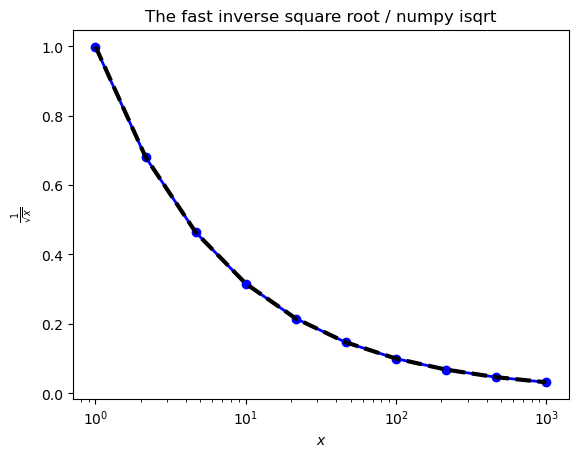

In [8]:
# We can make the above function it a numpy function in the following way.
# Suppose we want to plot the output
Npts      = 10
max_power = 3

# Create the x-values -> Note that astype -> this forces the numpy array to contain single precision floats.
xs = np.logspace(0, max_power, Npts).astype(np.float32)

# Create a numpy function from our C-function
Q_rsqrt_vec = np.vectorize(Q_rsqrt, otypes=[np.float32])

# Compute the approximation values
av = Q_rsqrt_vec(xs)

# Plot the result
plt.title('The fast inverse square root / numpy isqrt')
plt.semilogx(xs, av, marker='o', color='b', lw=2)
plt.semilogx(xs, 1./np.sqrt(xs), ls='--', color='k', lw=3)
plt.xlabel('$x$')
plt.ylabel('$\\frac{1}{\sqrt{x}}$')

# Fast-inverse square root (double precision)

In [13]:
%%writefile isqrt_pd.c
#include <stdint.h>
static double Q_rsqrt_pd(double x)
{
    uint64_t i;
    double x2, y;
    const double threehalfs = 1.5;

    x2 = x * 0.5;
    y  = x;
    i  = * ( uint64_t * ) &y;                   // evil floating point bit level hacking
    i  = 0x5fe6eb50c7b537a9 - ( i >> 1 );       // what the fuck?
    y  = * ( double * ) &i;
    y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
    return y; 
}

Overwriting isqrt_pd.c


In [14]:
%%writefile pyisqrt_pd.pyx
cdef extern from "isqrt_pd.c":
    cpdef double Q_rsqrt_pd(double x)

Overwriting pyisqrt_pd.pyx


In [15]:
%%writefile setup.py
from distutils.core import setup, Extension
from Cython.Build import cythonize
compileargs = ['-O2', '-fno-fast-math', '-fPIC', '-fwrapv', '-Wall', '-fno-strict-aliasing', '-Wno-unused-function']
ext = Extension('pyisqrt_pd', sources=['pyisqrt_pd.pyx', 'isqrt_pd.c'], extra_compile_args=compileargs)
setup(name='pyisqrt_pd', ext_modules=cythonize([ext], compiler_directives={'language_level': '3'}))

Overwriting setup.py


In [16]:
%%bash 
python setup.py build_ext --inplace

Compiling pyisqrt_pd.pyx because it changed.
[1/1] Cythonizing pyisqrt_pd.pyx
running build_ext
building 'pyisqrt_pd' extension
INFO: C compiler: /usr/bin/gcc -Wno-unused-result -Wsign-compare -DNDEBUG -fPIC

INFO: compile options: '-I/usr/include/python3.10 -c'
extra options: '-O2 -fno-fast-math -fPIC -fwrapv -Wall -fno-strict-aliasing -Wno-unused-function'
INFO: gcc: isqrt_pd.c
INFO: gcc: pyisqrt_pd.c
INFO: /usr/bin/gcc -shared build/temp.linux-x86_64-cpython-310/isqrt_pd.o build/temp.linux-x86_64-cpython-310/pyisqrt_pd.o -L/usr/lib64 -o build/lib.linux-x86_64-cpython-310/pyisqrt_pd.cpython-310-x86_64-linux-gnu.so
copying build/lib.linux-x86_64-cpython-310/pyisqrt_pd.cpython-310-x86_64-linux-gnu.so -> 


In [17]:
from pyisqrt_pd import Q_rsqrt_pd

In [19]:
Q_rsqrt_pd(2)

0.706929650795464

Text(0, 0.5, '$\\frac{1}{\\sqrt{x}}$')

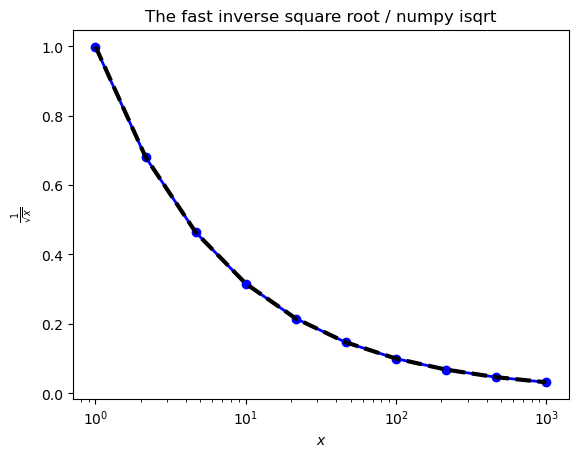

In [18]:
# We can make the above function it a numpy function in the following way.
# Suppose we want to plot the output
Npts      = 10
max_power = 3

# Create the x-values -> Note that astype -> this forces the numpy array to contain single precision floats.
xs = np.logspace(0, max_power, Npts).astype(np.float64)

# Create a numpy function from our C-function
Q_rsqrt_vec = np.vectorize(Q_rsqrt, otypes=[np.float64])

# Compute the approximation values
av = Q_rsqrt_vec(xs)

# Plot the result
plt.title('The fast inverse square root / numpy isqrt')
plt.semilogx(xs, av, marker='o', color='b', lw=2)
plt.semilogx(xs, 1./np.sqrt(xs), ls='--', color='k', lw=3)
plt.xlabel('$x$')
plt.ylabel('$\\frac{1}{\sqrt{x}}$')